In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sb

print(plt.style.available)
plt.style.use('seaborn')

plt.rcParams['figure.figsize'] = 8, 4

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn', u'seaborn-poster', u'seaborn-bright', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


In [3]:
from pymongo import MongoClient

def get_mongo_database(db_name, host='localhost', port=27017, username=None, password=None):
    '''Get (or create) named database from MongoDB with/out authentication'''
    if username and password:
        mongo_uri = 'mongodb://{}:{}@{}/{}'.format(username, password, host, db_name)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db_name]

def mongo_to_dataframe(db_name, collection_name, query={}, host='localhost',
                       port=27017, username=None, password=None, no_id=True):
    '''Create a Pandas DataFrame from MongoDB collection'''
    db = get_mongo_database(db_name, host, port, username, password)
    cursor = db[collection_name].find(query)
    df = pd.DataFrame(list(cursor))
    if no_id:
        del df['_id']
    return df

def dataframe_to_mongo(dframe, db_name, collection_name, host='localhost',
                 port=27017, username=None, password=None):
    '''save a dataframe to mongodb collection'''
    db = get_mongo_database(db_name, host, port, username, password)
    records = dframe.to_dict('records')  # 'records' puts it into our list-of-dicts format
    db[collection_name].insert_many(records)

def delete_collection(db_name, collection_name, host='localhost',
                 port=27017, username=None, password=None):
    '''save a dataframe to mongodb collection'''
    db = get_mongo_database(db_name, host, port, username, password)
    db[collection_name].delete_many({}) # empty filter deletes all entries


DB_NOBEL_PRIZE = 'nobel_prize' # use string constants or a spell error in retrieval will create new table.
COLL_WINNERS = 'winners' # winners collection



In [4]:
#----------------------------
# From json file.
#----------------------------
if True:
    with open('data/nwinners_all.json') as f:
        df = pd.read_json(f)

# Saving data
# Make sure mongodb is clear (so we don't duplicate data), then
# save to Mongo for next section
if False:
    db = get_mongo_database(DB_NOBEL_PRIZE)
    db[COLL_WINNERS].delete_many({})  # deletes everything (no filter)
    dataframe_to_mongo(df, DB_NOBEL_PRIZE, COLL_WINNERS) # save to Mongo for next section

#----------------------------
# From mongodb collection
#----------------------------
if False:  
    DB_NOBEL_PRIZE = 'nobel_prize' # use string constants or a spell error in retrieval will create new table.
    COLL_WINNERS = 'winners_all' # winners collection
    df = mongo_to_dataframe(DB_NOBEL_PRIZE, COLL_WINNERS)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 0 to 872
Data columns (total 15 columns):
award_age         873 non-null int64
bio_image         824 non-null object
category          873 non-null object
country           873 non-null object
date_of_birth     873 non-null object
date_of_death     592 non-null object
gender            873 non-null object
image_urls        873 non-null object
link              873 non-null object
mini_bio          873 non-null object
name              873 non-null object
place_of_birth    873 non-null object
place_of_death    592 non-null object
text              873 non-null object
year              873 non-null int64
dtypes: int64(2), object(13)
memory usage: 109.1+ KB


In [6]:
pd.to_datetime(df.date_of_birth) #DAY TODO - this is an issue -- all dates the same, 
                                 #time different when using the json input 
                                 #(use mongodb instead for dates)


0              1946-10-20
1     1878-11-01 00:00:00
2              1927-10-08
3              1931-11-26
4              1906-09-06
5     1887-04-10 00:00:00
6              1967-02-24
7              1951-09-30
8              1936-03-11
9              1936-10-10
10    1882-08-26 00:00:00
11    1887-07-22 00:00:00
12             1918-10-04
13             1901-03-27
14    1862-06-05 00:00:00
15    1833-02-19 00:00:00
16    1843-05-21 00:00:00
17             1905-09-30
18    1892-09-06 00:00:00
19    1886-09-13 00:00:00
20             1906-06-19
21             1941-02-19
22             1947-06-08
23             1920-05-29
24             1928-06-13
25             1919-04-22
26             1924-08-23
27             1940-05-24
28             1932-06-18
29             1936-11-19
              ...        
843            1918-07-15
844            1932-04-26
845            1929-11-02
846            1939-05-07
847            1932-11-06
848            1917-01-12
849            1917-10-02
850   1898-0

In [7]:
# convert the date columns to a usable form
df.date_of_birth = pd.to_datetime(df.date_of_birth)
df.date_of_death = pd.to_datetime(df.date_of_death)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 0 to 872
Data columns (total 15 columns):
award_age         873 non-null int64
bio_image         824 non-null object
category          873 non-null object
country           873 non-null object
date_of_birth     873 non-null datetime64[ns]
date_of_death     592 non-null datetime64[ns]
gender            873 non-null object
image_urls        873 non-null object
link              873 non-null object
mini_bio          873 non-null object
name              873 non-null object
place_of_birth    873 non-null object
place_of_death    592 non-null object
text              873 non-null object
year              873 non-null int64
dtypes: datetime64[ns](2), int64(2), object(11)
memory usage: 149.1+ KB


In [9]:
by_gender = df.groupby('gender')
print(by_gender.size())
print(df.loc[(df.year<=2015),:].groupby('gender').size()) #TODO different than book even though same years

gender
female     48
male      825
dtype: int64
gender
female     48
male      814
dtype: int64


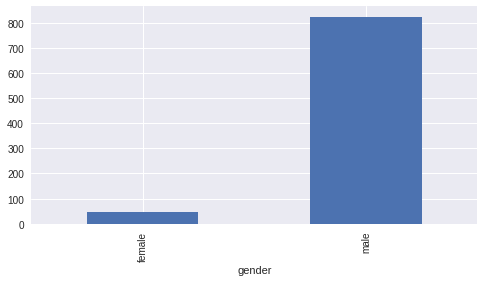

In [10]:
by_gender.size().plot(kind='bar')

In [11]:
by_cat_gen = df.groupby(['category', 'gender'])
by_cat_gen.get_group(('Physics', 'female'))[['name', 'year']] #get a group by a category and gender key

,name,year
115,Maria Goeppert-Mayer,1963
559,Marie Skłodowska-Curie,1903


In [12]:
by_cat_gen.size()

category                gender
Chemistry               female      4
                        male      170
Economics               female      1
                        male       78
Literature              female     14
                        male       96
Peace                   female     15
                        male       86
Physics                 female      2
                        male      200
Physiology or Medicine  female     12
                        male      195
dtype: int64

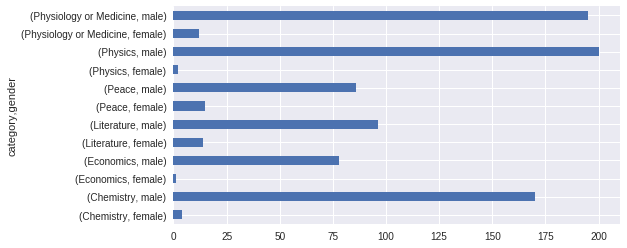

In [13]:
by_cat_gen.size().plot(kind='barh')

gender      female  male
category                
Chemistry        4   170
Economics        1    78
Literature      14    96
Peace           15    86
Physics          2   200


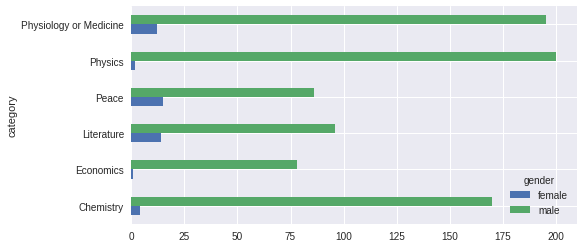

In [14]:
print(by_cat_gen.size().unstack().head())
by_cat_gen.size().unstack().plot(kind='barh')

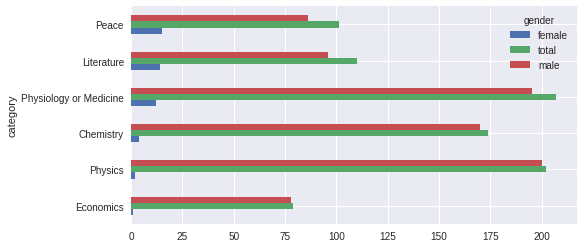

In [15]:
cat_gen_sz = by_cat_gen.size().unstack()
cat_gen_sz['total'] = cat_gen_sz.sum(axis=1)
cat_gen_sz = cat_gen_sz.sort_values(by='female', ascending=True)
cat_gen_sz[['female', 'total', 'male']].plot(kind='barh')

In [16]:
df[(df.category == 'Physics') & (df.gender == 'female')]\
[['name', 'country','year']]

,name,country,year
115,Maria Goeppert-Mayer,United States,1963
559,Marie Skłodowska-Curie,Poland,1903


## Function to reduce the number of x-ticks

In [17]:
# Reducing the number of x axis ticks
def thin_xticks(ax, tick_gap=10, rotation=45):
    """ Thin x-ticks and adjust rotation """
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    #print('debug: thin_xticks: ticklabels = {}'.format(ticklabels)) #debug
    ax.xaxis.set_ticks(ticks[::tick_gap])
    ax.xaxis.set_ticklabels(ticklabels[::tick_gap], rotation=rotation)
    ax.figure.show()


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


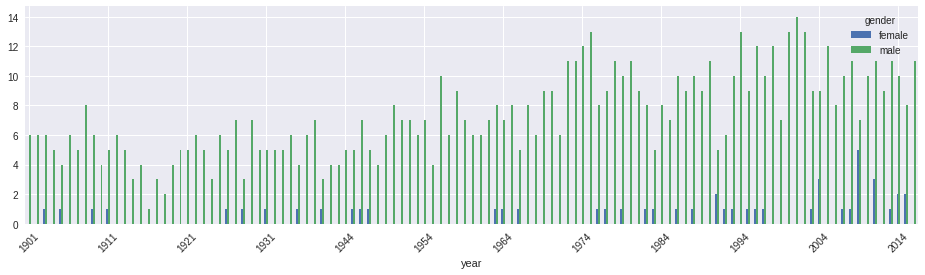

In [18]:
by_year_gender = df.groupby(['year','gender'])
year_gen_sz = by_year_gender.size().unstack()
ax = year_gen_sz.plot(kind='bar', figsize=(16,4))
thin_xticks(ax)

In [19]:
# the current unstacked group sizes use an automatic year index
by_year_gender = df.groupby(['year', 'gender'])
by_year_gender.size().unstack()

gender,female,male
year,,
1901,NaN,6.0
1902,NaN,6.0
1903,1.0,6.0
1904,NaN,5.0
1905,1.0,4.0
1906,NaN,6.0
1907,NaN,5.0
1908,NaN,8.0
1909,1.0,6.0


In [20]:
# However, there are some gap years where no prize was given and those
# gaps aren't in the dataframe right now.  Create a new index to make sure
# the gap years are represented:
new_index = pd.Index(np.arange(1901, 2016), name='year')
by_year_gender = df.groupby(['year','gender'])
year_gen_sz = by_year_gender.size().unstack().reindex(new_index)

year_gen_sz.loc[1935:1945, :] # now it has the gap years 1940, 41, 42


gender,female,male
year,,
1935,1.0,4.0
1936,NaN,6.0
1937,NaN,7.0
1938,1.0,3.0
1939,NaN,4.0
1940,NaN,NaN
1941,NaN,NaN
1942,NaN,NaN
1943,NaN,4.0


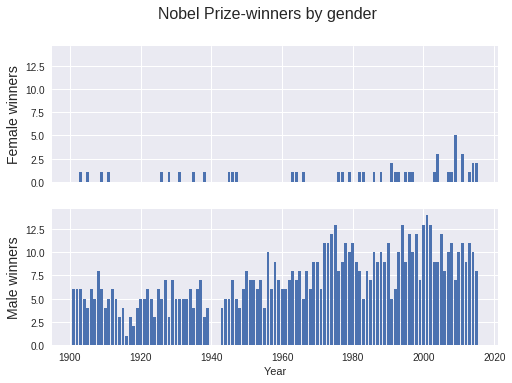

In [21]:
# Another problem with plot above is there are too many bars.
# have dedicated male and female plots but stacked so as to allow
# easy comparisons:
plt.style.use('seaborn')

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
ax_f = axes[0]
ax_m = axes[1]
fig.suptitle('Nobel Prize-winners by gender', fontsize=16)
ax_f.bar(year_gen_sz.index, year_gen_sz.female)
ax_f.set_ylabel('Female winners', fontsize=14)
ax_m.bar(year_gen_sz.index, year_gen_sz.male)
ax_m.set_ylabel('Male winners', fontsize=14)
ax_m.set_xlabel('Year')

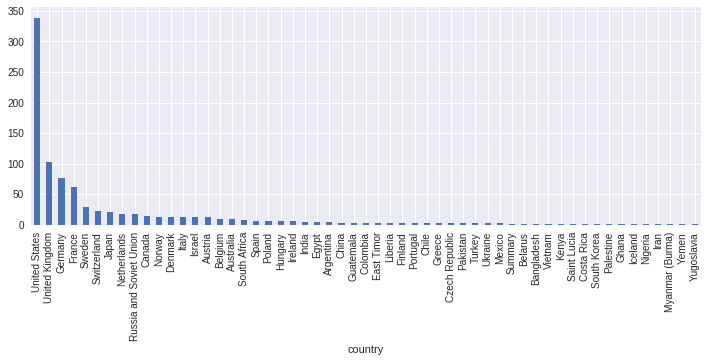

In [22]:
# Let's look at national trends.  Start with simple histogram
df.groupby('country').size().sort_values(ascending=False)\
.plot(kind='bar', figsize=(12,4))

In [23]:
nat_group = df.groupby('country')
ngsz = nat_group.size()
ngsz.index

Index([u'Argentina', u'Australia', u'Austria', u'Bangladesh', u'Belarus',
       u'Belgium', u'Canada', u'Chile', u'China', u'Colombia', u'Costa Rica',
       u'Czech Republic', u'Denmark', u'East Timor', u'Egypt', u'Finland',
       u'France', u'Germany', u'Ghana', u'Greece', u'Guatemala', u'Hungary',
       u'Iceland', u'India', u'Iran', u'Ireland', u'Israel', u'Italy',
       u'Japan', u'Kenya', u'Liberia', u'Mexico', u'Myanmar (Burma)',
       u'Netherlands', u'Nigeria', u'Norway', u'Pakistan', u'Palestine',
       u'Poland', u'Portugal', u'Russia and Soviet Union', u'Saint Lucia',
       u'South Africa', u'South Korea', u'Spain', u'Summary', u'Sweden',
       u'Switzerland', u'Turkey', u'Ukraine', u'United Kingdom',
       u'United States', u'Vietnam', u'Yemen', u'Yugoslavia'],
      dtype='object', name=u'country')

In [24]:
# Read in our countries data
if True:
    df_countries = pd.read_json('data/country_data.json', orient='record')
else:
    df_countries = mongo_to_dataframe('nobel_prize', 'countries')

In [25]:
df_countries.iloc[0] # show the first row by position

alpha2Code                                                       AF
alpha3Code                                                      AFG
altSpellings                                       [AF, Afġānistān]
area                                                         652230
borders                              [IRN, PAK, TKM, UZB, TJK, CHN]
callingCodes                                                   [93]
capital                                                       Kabul
currencies                                                    [AFN]
demonym                                                      Afghan
gini                                                           27.8
languages                                              [ps, uz, tk]
latlng                                                 [33.0, 65.0]
name                                                    Afghanistan
nativeName                                                افغانستان
numericCode                                     

In [26]:
# set the index to 'name'.  Then you can add the 'ngsz' Series
# that we created above which also has country name as index and
# it will match them up appropriately
df_countries = df_countries.set_index('name')
df_countries['nobel_wins'] = ngsz
df_countries['nobel_wins_per_capita'] =\
df_countries.nobel_wins / df_countries.population

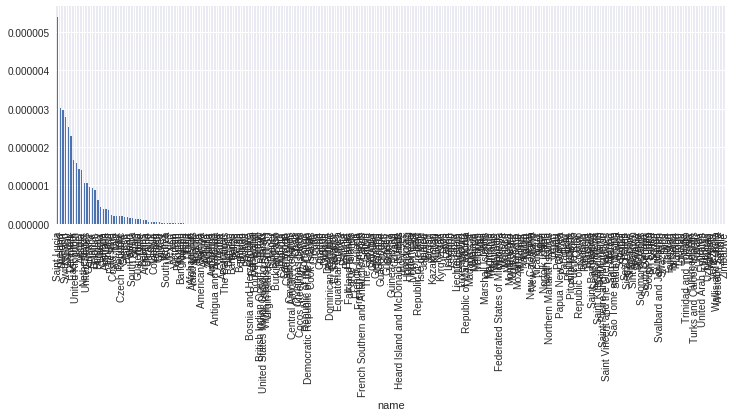

In [27]:
df_countries.sort_values(by='nobel_wins_per_capita', ascending=False)\
.nobel_wins_per_capita.plot(kind='bar', figsize=(12,4))

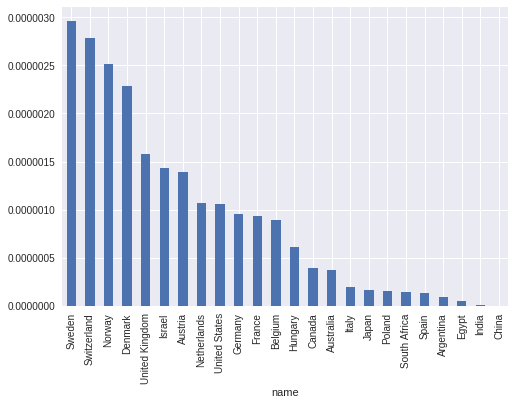

In [28]:
# filter for countries with more than two Nobel prizes
df_countries[df_countries.nobel_wins > 2]\
.sort_values(by='nobel_wins_per_capita', ascending=False)\
.nobel_wins_per_capita.plot(kind='bar')

In [29]:
# Now lets look at  wins by category
nat_cat_sz = df.loc[:2015,:].groupby(['country', 'category']).size().unstack()
nat_cat_sz[:5] # take the first five countries by category

# DAY TODO why doesn't this table match the book?  
# book shows Argentina having 2 Chemistry prizes, for example.

category,Chemistry,Economics,Literature,Peace,Physics,Physiology or Medicine
country,,,,,,
Argentina,1.0,NaN,NaN,1.0,NaN,2.0
Australia,NaN,1.0,1.0,NaN,1.0,6.0
Austria,2.0,NaN,1.0,2.0,3.0,4.0
Bangladesh,NaN,NaN,NaN,1.0,NaN,NaN
Belarus,NaN,NaN,1.0,NaN,NaN,NaN


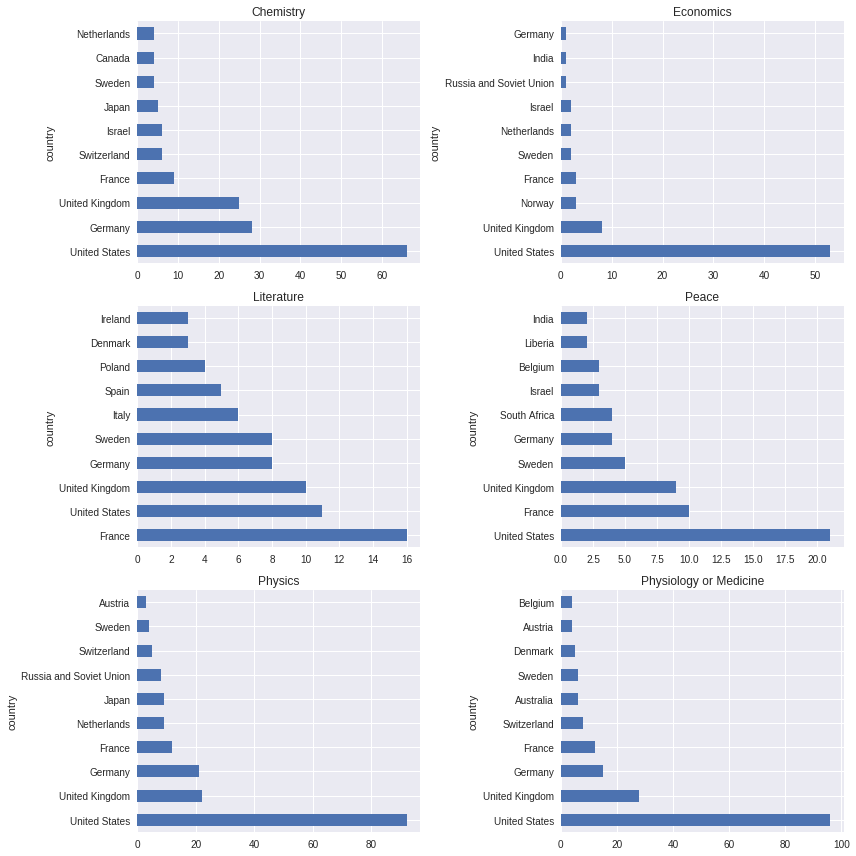

In [30]:
COL_NUM = 2
ROW_NUM = 3
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))
for i, (label, col) in enumerate(nat_cat_sz.iteritems()):
    ax = axes[i//COL_NUM, i%COL_NUM]
    col = col.sort_values(ascending=False)[:10]
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)
plt.tight_layout()

# Historical Trends in Prize Distribution

In [31]:
# increase the font size 
plt.rcParams['font.size'] = 20

In [32]:
new_index = pd.Index(np.arange(1901, 2016), name='year') #fills in the gap years
by_year_nat_sz = df.groupby(['year', 'country'])\
.size().unstack().reindex(new_index)

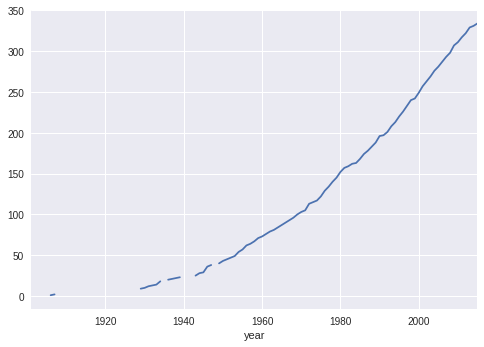

In [33]:
by_year_nat_sz['United States'].cumsum().plot()

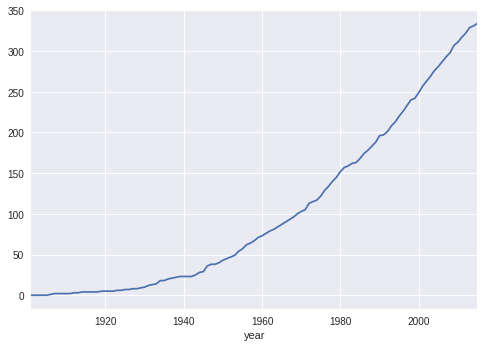

In [34]:
# for years where the US won no prize, cumsum() returns NaN
# let's replace those NaN with zeros
by_year_nat_sz['United States'].fillna(0).cumsum().plot()

[u'Argentina', u'Australia', u'Austria', u'Bangladesh', u'Belarus', u'Belgium', u'Canada', u'Chile', u'China', u'Colombia', u'Costa Rica', u'Czech Republic', u'Denmark', u'East Timor', u'Egypt', u'Finland', u'France', u'Germany', u'Ghana', u'Greece', u'Guatemala', u'Hungary', u'Iceland', u'India', u'Iran', u'Ireland', u'Israel', u'Italy', u'Japan', u'Kenya', u'Liberia', u'Mexico', u'Myanmar (Burma)', u'Netherlands', u'Nigeria', u'Norway', u'Pakistan', u'Palestine', u'Poland', u'Portugal', u'Russia and Soviet Union', u'Saint Lucia', u'South Africa', u'South Korea', u'Spain', u'Summary', u'Sweden', u'Switzerland', u'Turkey', u'Ukraine', u'United Kingdom', u'Vietnam', u'Yemen', u'Yugoslavia']


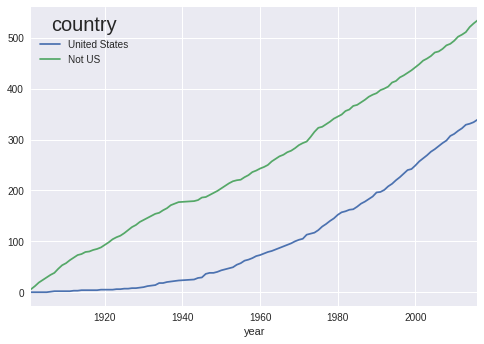

In [35]:
# Compare the US to the rest of the world
by_year_nat_sz = df.groupby(['year', 'country']).size().unstack().fillna(0)
not_US = by_year_nat_sz.columns.tolist() # get list of country column names
not_US.remove('United States') #remove "United States" from list of names
print(not_US)
# now use not_US column name list to create a 'Not US' column with
# sum of all prizes for countries not in the not_US list.
by_year_nat_sz['Not US'] = by_year_nat_sz.loc[:,not_US].sum(axis=1)
ax = by_year_nat_sz.loc[:,['United States', 'Not US']].cumsum().plot()

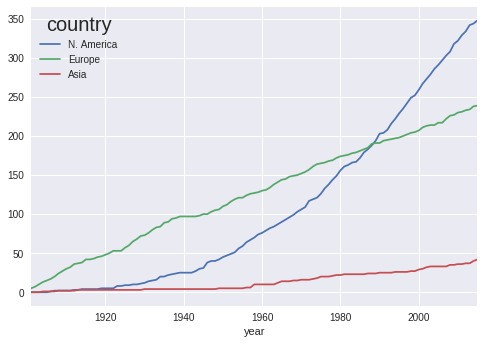

In [36]:
# Look at regional differences
new_index = pd.Index(np.arange(1901, 2016), name='year') #fills in the gap years
by_year_nat_sz = df.groupby(['year', 'country'])\
                    .size().unstack().reindex(new_index).fillna(0)
    
# Create a region column with 2 or 3 largest countries in each region
regions = [
{'label':'N. America',
'countries':['United States', 'Canada']},
{'label':'Europe',
'countries':['United Kingdom', 'Germany', 'France']},
{'label':'Asia',
'countries':['Japan', 'Russia and Soviet Union', 'India']}
]
for region in regions:
    by_year_nat_sz[region['label']] =\
    by_year_nat_sz.loc[:,region['countries']].sum(axis=1)
    
by_year_nat_sz.loc[:,[r['label'] for r in regions]].cumsum().plot()

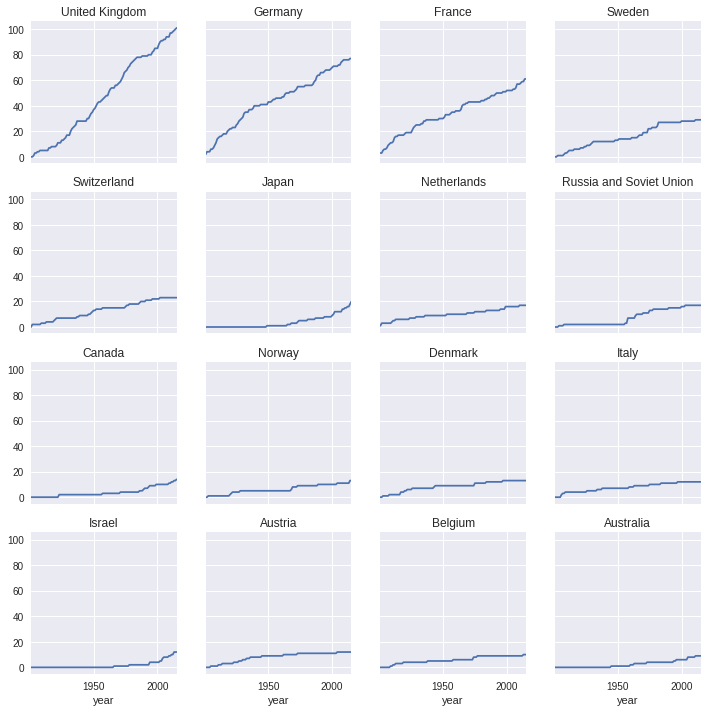

In [37]:
COL_NUM = 4 
ROW_NUM = 4

by_nat_sz = df.groupby('country').size()
by_nat_sz.sort_values(ascending=False, inplace=True) #sort countries from highest to lowest win haul
fig, axes = plt.subplots(COL_NUM, ROW_NUM, sharex=True, sharey=True, figsize=(12,12))
for i, nat in enumerate(by_nat_sz.index[1:17]): # enumerate from 2nd row (1) excluding the US (0)
    ax = axes[i//COL_NUM, i%ROW_NUM]
    by_year_nat_sz.loc[:,nat].cumsum().plot(ax=ax)
    ax.set_title(nat)

In [38]:
import seaborn as sns
plt.style.use('seaborn')

See list of [colormaps here](https://matplotlib.org/users/colormaps.html#overview)
You can also apppend "_r" to any of these to reverse them.

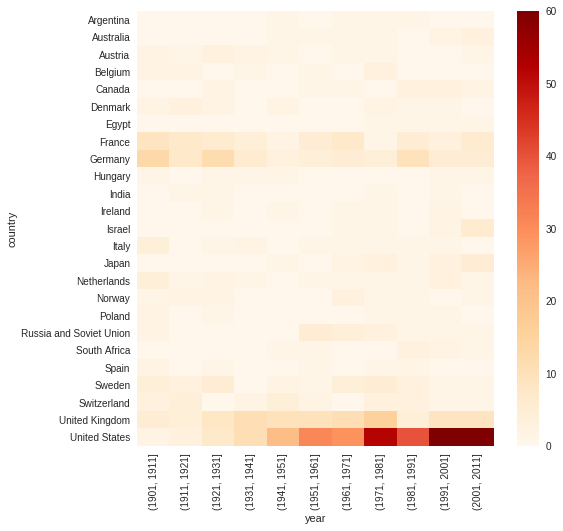

In [40]:
# create categorical buckets out of the continuous year
bins = np.arange(df.year.min(), df.year.max(), 10)
by_year_nat_binned = df.groupby(
        ['country', pd.cut(df.year, bins, precision=0)]).size().unstack().fillna(0)
plt.figure(figsize=(8,8))
#sns.heatmap(by_year_nat_binned[by_year_nat_binned.sum(axis=1) > 2], cmap="YlGnBu")
#sns.heatmap(by_year_nat_binned[by_year_nat_binned.sum(axis=1) > 2], cmap="gist_earth_r")
#sns.heatmap(by_year_nat_binned[by_year_nat_binned.sum(axis=1) > 2], cmap="RdBu_r")
sns.heatmap(by_year_nat_binned[by_year_nat_binned.sum(axis=1) > 2], cmap="OrRd")


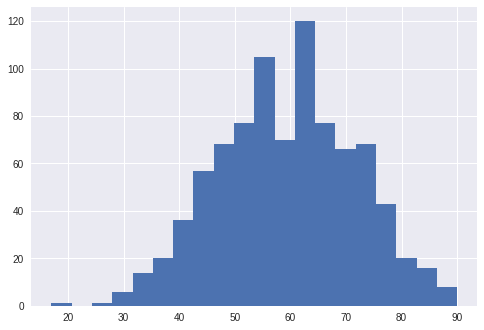

In [41]:
df['award_age'].hist(bins=20)

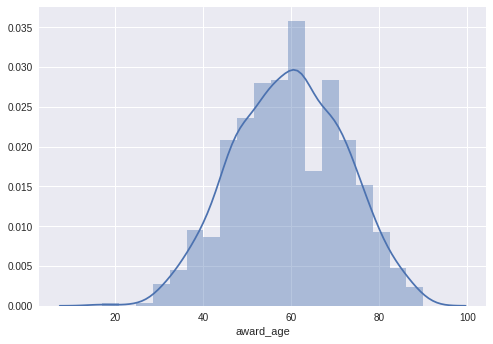

In [42]:
sns.distplot(df['award_age'])

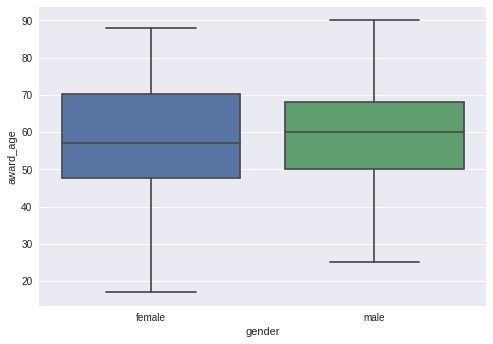

In [43]:
sns.boxplot(df.gender, df.award_age)

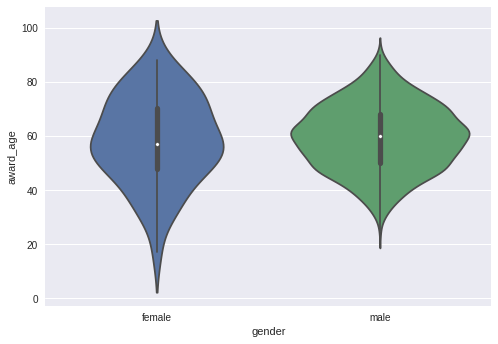

In [44]:
sns.violinplot(df.gender, df.award_age)

In [45]:
df['age_at_death'] = (df.date_of_death - df.date_of_birth).dt.days/365

In [47]:
df.date_of_birth.head()



0            1946-10-20
1   1878-11-01 00:00:00
2            1927-10-08
3            1931-11-26
4            1906-09-06
Name: date_of_birth, dtype: datetime64[ns]

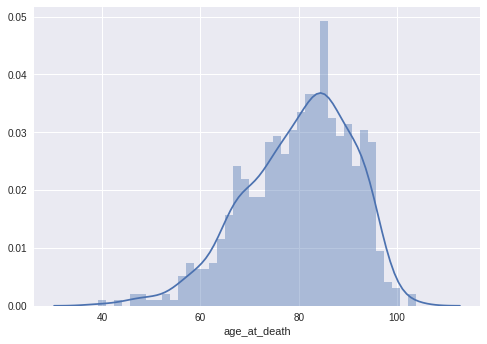

In [48]:
age_at_death = df[df.age_at_death.notnull()].age_at_death
sns.distplot(age_at_death, bins=40)

In [49]:
df[df.age_at_death > 100][['name', 'category', 'year']]

,name,category,year
217,Rita Levi-Montalcini,Physiology or Medicine,1986
227,Ronald Coase,Economics,1991


In [50]:
df_temp = df[df.age_at_death.notnull()]

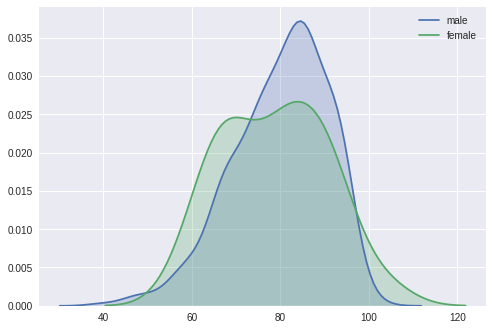

In [51]:
sns.kdeplot(df_temp[(df_temp.gender == 'male')].age_at_death, shade=True, label='male')
sns.kdeplot(df_temp[(df_temp.gender == 'female')].age_at_death, shade=True, label='female')
plt.legend()

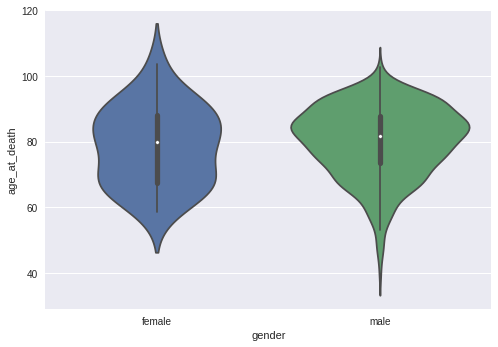

In [52]:
sns.violinplot(df.gender, age_at_death)

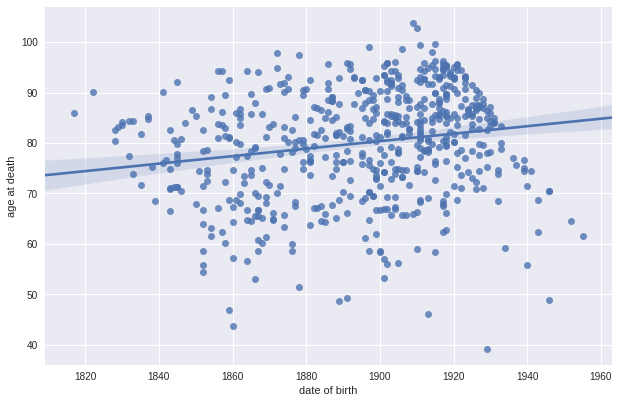

In [53]:
df_temp=df[df.age_at_death.notnull()]
data = pd.DataFrame(
{'age at death':df_temp.age_at_death,
'date of birth':df_temp.date_of_birth.dt.year})
sns.lmplot('date of birth', 'age at death', data, size=6, aspect=1.5)

In [54]:
df = pd.read_json('data/nobel_winners_plus_bornin.json', orient='records')
df

,born_in,category,country,date_of_birth,date_of_death,gender,link,name,place_of_birth,place_of_death,text,year
0,Austria,Physiology or Medicine,NaN,7 November 1929,None,male,https://en.wikipedia.org/wiki/Eric_Kandel,Eric Kandel *,Vienna,None,"Eric Kandel *, Physiology or Medicine, 2000",2000
1,Austria,Chemistry,NaN,9 March 1923,19 April 2016,male,https://en.wikipedia.org/wiki/Walter_Kohn,Walter Kohn *,Vienna,Santa Barbara,"Walter Kohn *, Chemistry, 1998",1998
2,Australia,Physiology or Medicine,NaN,26 November 1948,None,female,https://en.wikipedia.org/wiki/Elizabeth_Blackburn,Elizabeth Blackburn *,Hobart,None,"Elizabeth Blackburn *, Physiology or Medicine,...",2009
3,United States,Literature,NaN,26 September 1888,4 January 1965,male,https://en.wikipedia.org/wiki/T._S._Eliot,T. S. Eliot *,St. Louis,London,"T. S. Eliot *, Literature, 1948",1948
4,United States,Literature,NaN,30 June 1911,14 August 2004,male,https://en.wikipedia.org/wiki/Czes%C5%82aw_Mi%...,Czesław Miłosz *,Šeteniai,Kraków,"Czesław Miłosz *, born in then Russian Empire...",1980
5,United States,Physiology or Medicine,NaN,9 January 1922,9 November 2011,male,https://en.wikipedia.org/wiki/Har_Gobind_Khorana,Har Gobind Khorana *,Raipur,Concord,"Har Gobind Khorana *, born in India , Physiol...",1968
6,United States,Physics,NaN,9 July 1926,None,male,https://en.wikipedia.org/wiki/Ben_R._Mottelson,Ben R. Mottelson *,Chicago,None,"Ben R. Mottelson *, Physics, 1975",1975
7,United States,Physics,NaN,19 October 1910,21 August 1995,male,https://en.wikipedia.org/wiki/Subrahmanyan_Cha...,Subrahmanyan Chandrasekhar *,Lahore,Chicago,"Subrahmanyan Chandrasekhar *, born in India ,...",1983
8,United States,Economics,NaN,5 March 1934,None,male,https://en.wikipedia.org/wiki/Daniel_Kahneman,Daniel Kahneman *,Tel Aviv,None,"Daniel Kahneman *, born in Israel , Economic...",2002
9,United States,Economics,NaN,8 June 1930,None,male,https://en.wikipedia.org/wiki/Robert_Aumann,Robert Aumann *,Frankfurt,None,"Robert Aumann *, as an Israeli citizen , Ec...",2005


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


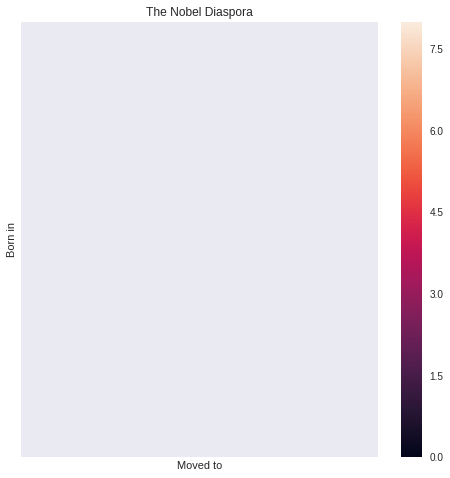

In [55]:
by_bornin_nat = df[df.born_in.notnull()].groupby(\
        ['born_in', 'country']).size().unstack()
by_bornin_nat.index.name = 'Born in'
by_bornin_nat.columns.name = 'Moved to'
plt.figure(figsize=(8,8))
ax = sns.heatmap(by_bornin_nat, vmin=0, vmax=8)
ax.set_title('The Nobel Diaspora')

In [65]:
df.date_of_birth = pd.to_datetime(df.date_of_birth).dt.date

In [66]:
df.loc[(df.born_in == 'Germany') & (df.country == 'United Kingdom'), ['name', 'date_of_birth', 'category']]

TypeError: invalid type comparison